In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch import optim
from torchvision.datasets import CIFAR10,MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from torchsummary import summary

In [32]:
t=transforms.Compose([  transforms.ToTensor(),
                        transforms.Normalize((0.5),(0.5)),
                        ])

In [33]:
# train_data=CIFAR10(root=r"./data",train=True,transform=t,download=True)
# test_data=CIFAR10(root=r"./data",train=False,transform=t,download=True)
train_data=MNIST(root=r"./data",train=True,transform=t,download=True)
test_data=MNIST(root=r"./data",train=False,transform=t,download=True)


In [34]:
train_loader=DataLoader(train_data,batch_size=128,shuffle=True)
test_loader=DataLoader(test_data,batch_size=128,shuffle=False)


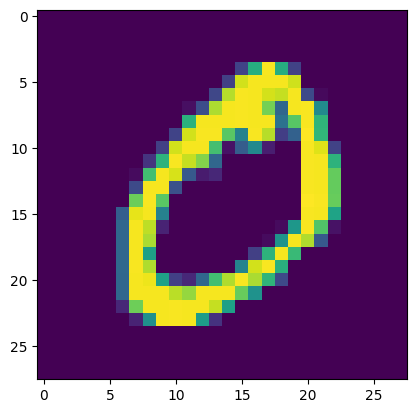

In [35]:
plt.imshow(train_data[1][0][0])
plt.show()

In [59]:
5*5*16

400

In [ ]:
class CIFAR_Module(nn.Module):
    def __init__(self,in_channel):
        self.in_channel=in_channel
        super(CIFAR_Module,self).__init__()
        self.con1=nn.Conv2d(in_channels=in_channel,out_channels=6*in_channel,kernel_size=5,stride=1,padding=2)
        self.pool1=nn.AvgPool2d(2,stride=2)
        self.con2=nn.Conv2d(in_channels=6*in_channel,out_channels=16*in_channel,kernel_size=5,stride=1)
        self.flat=nn.Flatten()
        self.fc1=nn.Linear(5*5*16*in_channel,120*in_channel)
        self.fc2=nn.Linear(120*in_channel,84*in_channel)
        self.fc3=nn.Linear(84*in_channel,10)
    def forward(self,x):
        
        x=self.con1(x)
        x=f.tanh(x)
        x=self.pool1(x)
        
        x=self.con2(x)
        x=f.tanh(x)
        x=self.pool1(x)
        
        x=self.flat(x)
        x=self.fc1(x)
        x=f.tanh(x)
        x=self.fc2(x)
        x=f.tanh(x)
        x=self.fc3(x)
        return x

In [62]:
in_channel=1
model=CIFAR_Module(in_channel)
criterian=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)


In [63]:
summary(model,input_size=(in_channel,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         AvgPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         AvgPool2d-4             [-1, 16, 5, 5]               0
           Flatten-5                  [-1, 400]               0
            Linear-6                  [-1, 120]          48,120
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


In [64]:
print(model)

CIFAR_Module(
  (con1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (con2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [65]:
# num_epoch=len(train_loader)
num_epoch=10
for epoch in range(num_epoch):
    running_loss=0.0
    best=0.0
    for image,label in train_loader:
        output=model(image)
        loss=criterian(output,label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss+=loss.item()
    print(f"epoch[{epoch+1}/{num_epoch}]- loss:{running_loss/len(train_loader)}")
    model.eval()
    with torch.no_grad():
        correct=0.0
        total=0.0
        for image,label in test_loader:
            output=model(image)
            _,predicted=torch.max(output,1)
            correct+=(predicted==label).sum().item()
            total+=label.size(0)
        accuracy=(correct/total)*100
        print(f"accuracy: {(correct/total)*100}")
        if accuracy>best:
            torch.save(model.state_dict(),"MNIST_model.pth")

epoch[1/10]- loss:0.3529765844059143
accuracy: 96.02000000000001
epoch[2/10]- loss:0.10809560046632534
accuracy: 97.1
epoch[3/10]- loss:0.06943205887201562
accuracy: 97.78
epoch[4/10]- loss:0.05509788697875385
accuracy: 98.11
epoch[5/10]- loss:0.04190635992519891
accuracy: 98.39
epoch[6/10]- loss:0.03626983411071985
accuracy: 98.29
epoch[7/10]- loss:0.029026232327449757
accuracy: 98.35000000000001
epoch[8/10]- loss:0.02467093761858425
accuracy: 98.42999999999999
epoch[9/10]- loss:0.020662838421729224
accuracy: 98.44000000000001
epoch[10/10]- loss:0.017786313667952983
accuracy: 98.61999999999999


In [66]:
model.eval()
with torch.no_grad():
    correct=0.0
    total=0.0
    for image,label in test_loader:
        output=model(image)
        _,predicted=torch.max(output,1)
        correct+=(predicted==label).sum().item()
        total+=label.size(0) 
    print(f"accuracy: {(correct/total)*100}")

accuracy: 98.61999999999999


In [67]:
labels=[]
for image,label in test_data:
    labels.append(label)
set(labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}